# Clustering
## Iris dataset Loading and standardization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score as sc

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 1- Apply K-Means 
### 1.1 K-Means with k=3

* Build a K-Means algorithm with k=3, the centroids initialization by 'k-means++' and random_state=42
* Generate the label for each data point
* Compute the overall silhouette coefficient 'silhouette_score'


In [27]:
# Apply KMeans with k=3
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(X_scaled)
labels = kmeans.labels_

# Calculate the silhouette score
sil_score = sc(X_scaled, labels)

print(f'silhouette_score = {sil_score:.3f}')


silhouette_score = 0.480


### 1.2 Analysis the silhouette score for different values of k
#### 1.2.1 Manual Grid search using for-loop

silhouette_score for k=2 = 0.58
silhouette_score for k=3 = 0.48
silhouette_score for k=4 = 0.39
silhouette_score for k=5 = 0.35
silhouette_score for k=6 = 0.33
silhouette_score for k=7 = 0.27
silhouette_score for k=8 = 0.34
silhouette_score for k=9 = 0.32
silhouette_score for k=10 = 0.34


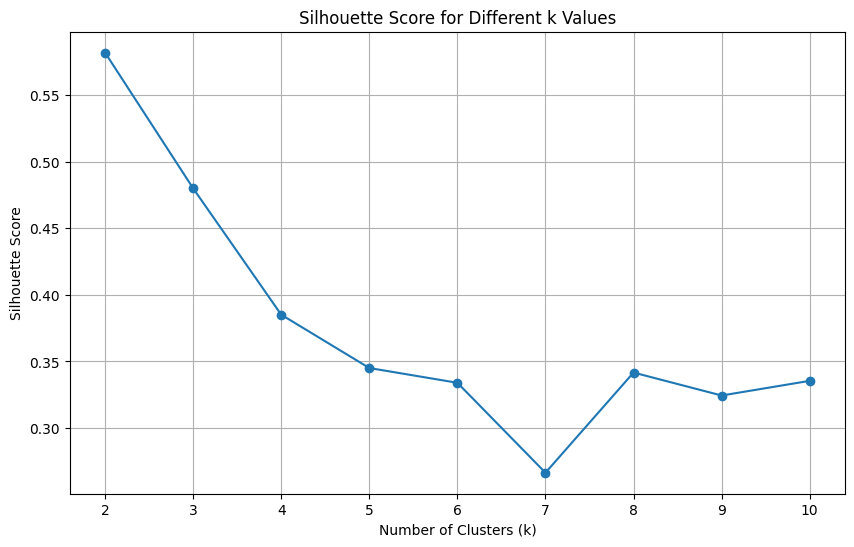

In [6]:
# Define the range of k values
k_values = range(2, 11)
silhouette_scores = []

# Iterate over k values and calculate silhouette scores
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X_scaled)
    cluster_labels = kmeans.labels_
    sil_score = sc(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)
    print(f'silhouette_score for k={k} = {sil_score:.2f}')

# Plot k values vs silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

#### 1.2.2 Grid search using GridsearchCV form Scikit-learn

Best number of clusters (k): 2
Best silhouette score: 0.582


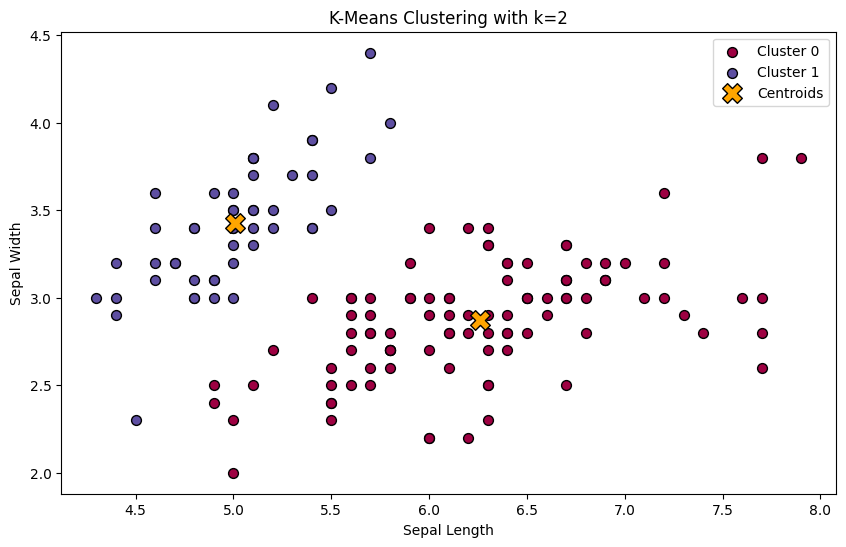

In [26]:
# Define a custom scorer using silhouette_score
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))-(1 if -1 in cluster_labels else 0)
    num_samples = X.shape[0]
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return sc(X, cluster_labels)

# Define the parameter grid
param_grid = {'n_clusters': np.arange(2, 11)}

# Define the custom CV split as provided
cv_splits = [(slice(None), slice(None))]

# Use GridSearchCV with the custom scorer and custom CV split
grid_search = GridSearchCV(estimator=KMeans(random_state=42, init='k-means++'),
                           param_grid=param_grid,
                           scoring=cv_silhouette_scorer,
                           cv=cv_splits,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_scaled)

# Get the best number of clusters
best_k = grid_search.best_params_['n_clusters']
best_score = grid_search.best_score_
labels = grid_search.best_estimator_.labels_
centroids = grid_search.best_estimator_.cluster_centers_

print(f'Best number of clusters (k): {best_k}')
print(f'Best silhouette score: {best_score:.3f}')

# Results for all k values
results = pd.DataFrame(grid_search.cv_results_)

# Show clusters and the centroids in the original range of the features
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'  # Black used for noise.
        label = 'Outliers'
    else:
        label = f'Cluster {k}'
        
    plt.scatter(X[(labels == k), 0], X[(labels == k), 1], color=col, edgecolor='k', s=50, label=label)
# scatter the centroids
centroids_viz = scaler.inverse_transform(centroids)[:, :2]
plt.scatter(centroids_viz[:, 0], centroids_viz[:, 1], c='orange', edgecolor='k', s=200, marker='X', label='Centroids')

plt.title(f'K-Means Clustering with k={best_k}')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()

## 2- Apply DBSCAN
### 2.1 Manual Grid search 

* Generate the combinations of hyperparameters epsilon and kmin manually using "numpy.meshgrid" and two for-loops
* Build a DBSCAN algorithm for each combination
* Compute the number of outliers and show the number of clusters


In [29]:
# Generate an array of combinations for hyperparameters epsilon and kmin
eps = np.arange(0.2, 1.5, 0.2)
kmin = np.arange(2, 6, 2)
EPS, KMIN = np.meshgrid(eps, kmin)
outlier = np.zeros(EPS.shape)
cluster_numbers = np.zeros(EPS.shape)  
silhouette_scores = np.zeros(EPS.shape)

# Gridsearch For-Loops
for m in range(eps.shape[0]):
    for n in range(kmin.shape[0]):
        db = DBSCAN(min_samples=KMIN[n, m], eps=EPS[n, m], metric='euclidean').fit(X_scaled)
        labels = db.labels_
        outlier[n, m] = list(labels).count(-1)
        cluster_numbers[n, m] = len(set(labels)) - (1 if -1 in labels else 0)
        
        if cluster_numbers[n, m] > 1:  # Silhouette score is only valid if there is more than one cluster
            sil_score = sc(X_scaled, labels)
        else:
            sil_score = -1  # Invalid silhouette score
        
        silhouette_scores[n, m] = sil_score

# Find the maximum silhouette score and the corresponding parameters
max_sil_score = np.max(silhouette_scores)
max_index = np.unravel_index(silhouette_scores.argmax(), silhouette_scores.shape)
best_eps = EPS[max_index]
best_kmin = KMIN[max_index]
best_outlier = outlier[max_index]
best_cluster_number = cluster_numbers[max_index]

print(f'Max silhouette score: {max_sil_score:.3f}')
print(f'Best eps: {best_eps:.2f}')
print(f'Best kmin: {best_kmin}')
print(f'Number of clusters: {best_cluster_number}')
print(f'Number of outliers: {best_outlier}')
        


Max silhouette score: 0.582
Best eps: 1.40
Best kmin: 2
Number of clusters: 2.0
Number of outliers: 0.0


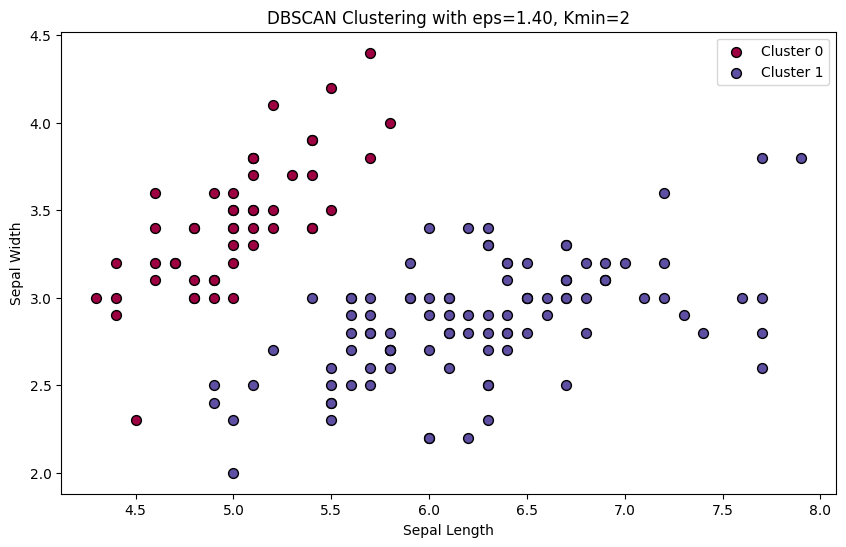

In [30]:
# Perform DBSCAN with the best parameters
db_best = DBSCAN(min_samples=best_kmin, eps=best_eps, metric='euclidean').fit(X_scaled)

labels= db_best.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'  # Black used for noise.
        label = 'Outliers'
    else:
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, edgecolor='k', s=50, label=label)

plt.title(f'DBSCAN Clustering with eps={best_eps:.2f}, Kmin={int(best_kmin)}')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()

### 2.2 Grid search using GridsearchCV form Scikit-learn

Best eps: 1.4
Best min_samples: 2
Best silhouette score: 0.582


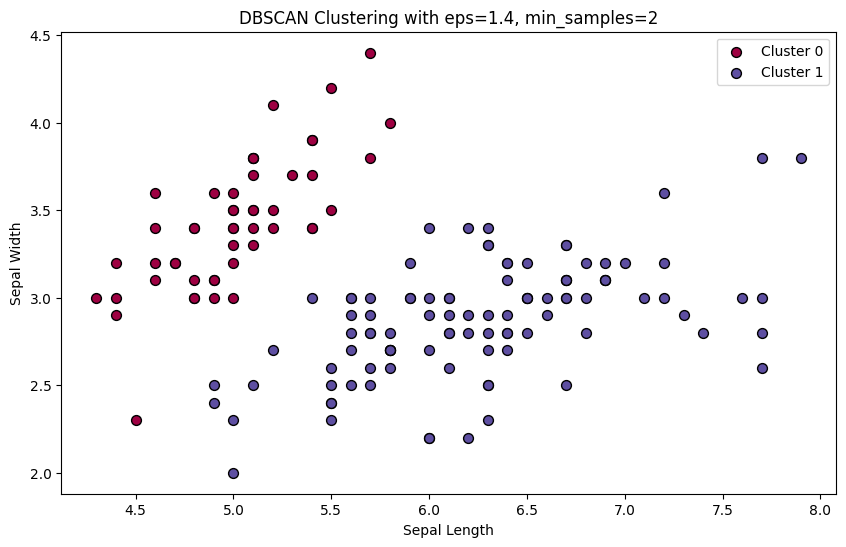

In [31]:
# Define the parameter grid for DBSCAN
param_grid = {
    'eps': np.arange(0.2, 1.5, 0.2),
    'min_samples': np.arange(2, 6, 2)
}

# Define the custom CV split as provided
cv_splits = [(slice(None), slice(None))]

# Use GridSearchCV with the custom scorer and custom CV split
grid_search = GridSearchCV(estimator=DBSCAN(metric='euclidean'),
                           param_grid=param_grid,
                           scoring=cv_silhouette_scorer,
                           cv=cv_splits,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_scaled)

# Get the best parameters
best_eps = grid_search.best_params_['eps']
best_min_samples = grid_search.best_params_['min_samples']
best_score = grid_search.best_score_
labels = grid_search.best_estimator_.labels_

print(f'Best eps: {best_eps:.1f}')
print(f'Best min_samples: {best_min_samples}')
print(f'Best silhouette score: {best_score:.3f}')

# Results for all hyperparameters combinations
results = grid_search.cv_results_

# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'  # Black used for noise.
        label = 'Outliers'
    else:
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, edgecolor='k', s=50, label=label)

plt.title(f'DBSCAN Clustering with eps={best_eps:.1F}, min_samples={best_min_samples}')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()

It is the same results like the manuall Grid search

### Choosing the range of epsilon:


Below is the calculation of the distances for all combinations of points and the dermination of the distance that has 2% relative frequancy.
<br>
* 2 % of the parts have a distance of 0.5 or less in this example
* Parameter selected slightly above this range. The range from 0.2 to 1.5 is explored above.

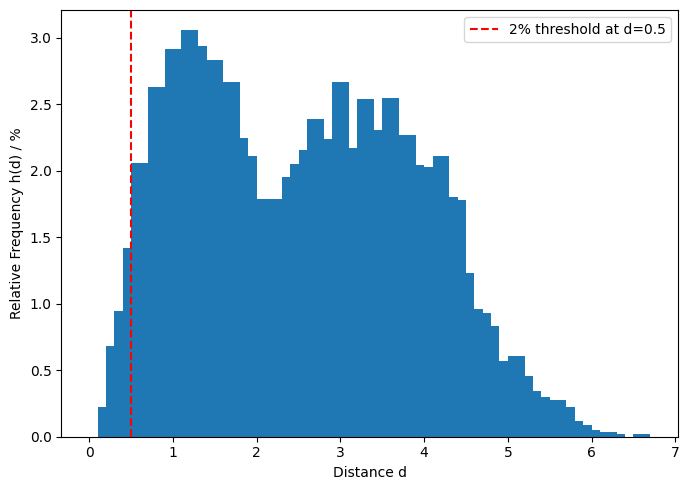

In [32]:
# Distances for all combinations of points
diff = (X_scaled[np.newaxis, :, :] - X_scaled[:, np.newaxis, :])

dist = pd.Series(np.sqrt((diff**2).sum(axis=2)).reshape(-1))

# Define the classes and calculate relative frequencies. 0.1 represents the resultion that classifies the distances into classes
classes = np.arange(0, dist.max()+0.1, 0.1)
frequency_rel = dist.value_counts(normalize=True, sort=False, bins=classes)
frequency_rel.iloc[0] = 0

# Plot the relative frequency
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.bar(classes[0:-1] + 0.1, frequency_rel * 100, width=0.2)
ax1.set_xlabel("Distance d")
ax1.set_ylabel("Relative Frequency h(d) / %")

# Annotate the point where relative frequency equals 2% and add a vertical line
threshold = 2.0
for i, freq in enumerate(frequency_rel):
    if freq * 100 >= threshold:
        ax1.axvline(x=classes[i], color='r', linestyle='--', label=f'2% threshold at d={classes[i]:.1f}')
        break

plt.legend()
plt.tight_layout()
plt.show()